In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def prepare_data(path):
    data = np.load(path)
    
    data = data.transpose((0, 4, 2, 3, 1))
    data = data.reshape(data.shape[0], 15, 15, 2)
    
    # normalization
    mean = np.mean(data)
    std  = np.std(data)
    data = (data - mean)/(std+1e-7)
    
    return data

In [ ]:
data_pos = prepare_data('/content/gdrive/My Drive/data/stereo_matching/cosine_2.npy')
print(data_pos.shape)

(1000000, 15, 15, 2)


In [ ]:
data_pos = np.concatenate([data_pos[:,:,:,:1], data_pos[:,:,:,:1]], axis=3)
print(data_pos.shape)

(1000000, 15, 15, 2)


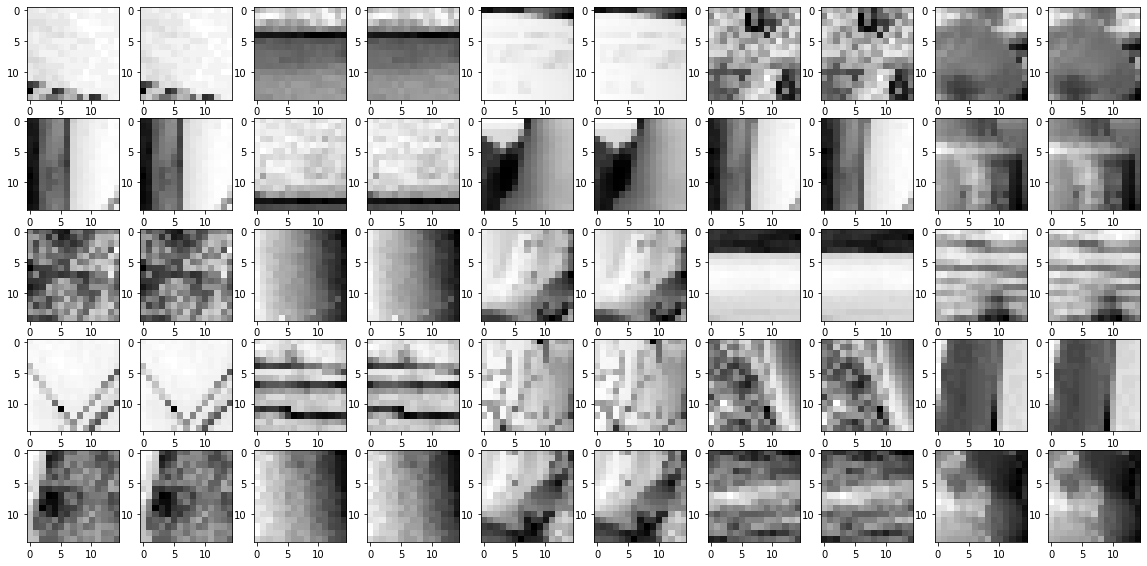

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
count = 1
for i in range(25):
    for j in range(2):
        plt.subplot(10,10,count) # (nrows, ncols, index)
        plt.imshow(data_pos[i,:,:,j], 'gray')
        count += 1
plt.show()

In [ ]:
# get data
data_neg = prepare_data('/content/gdrive/My Drive/data/stereo_matching/cosine_1.npy')
print(data_neg.shape)

# get labels
Y_neg = np.zeros((data_neg.shape[0],))
print(Y_neg.shape)

Y_pos = np.ones((data_neg.shape[0],))
print(Y_pos.shape)

(1000000, 15, 15, 2)
(1000000,)
(1000000,)


In [ ]:
Y_neg = Y_neg.reshape(-1, 1)
print(Y_neg.shape)

Y_pos = Y_pos.reshape(-1, 1)
print(Y_pos.shape)

(1000000, 1)
(1000000, 1)


In [ ]:
data_pos = np.array([data_neg, data_pos])
data_pos = np.vstack(data_pos)
print(data_pos.shape)

Y_pos = np.array([Y_neg, Y_pos])
Y_pos = np.vstack(Y_pos)
Y_pos = Y_pos.squeeze()
print(Y_pos.shape)

(2000000, 15, 15, 2)
(2000000,)


In [ ]:
# shuffle
data_size = data_pos.shape[0]

rng = np.random.RandomState(113)
indices = np.arange(data_size)

rng.shuffle(indices)
data_pos = data_pos[indices]
Y_pos = Y_pos[indices]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
import tensorflow as tf

aug_layer = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
  layers.experimental.preprocessing.RandomRotation(factor=0.2),
  layers.experimental.preprocessing.Resizing(18, 18),
  tf.keras.layers.experimental.preprocessing.RandomCrop(height=15, width=15)  # elastic distortion
])

def base_model(input_shape):
    inputs = Input(shape=input_shape)
    x = aug_layer(inputs) #
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.squeeze(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
model = base_model((None, None, 1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
sequential (Sequential)      (None, 15, 15, 2)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        608       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          9248  

In [ ]:
X = tf.random.normal((128, 15, 15, 2))
Y = tf.random.normal((128,))

print(X.shape)
print(Y.shape)

(128, 15, 15, 2)
(128,)


In [ ]:
# predict
pred = model(X)

# loss
print(pred.shape)
print(Y.shape)

(128,)
(128,)


In [ ]:
# training
batch_size = 512
epochs = 15

opt_adam = keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt_adam)
history = model.fit(data_pos, Y_pos, batch_size = batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/15
3125/3125 [==============================] - 69s 11ms/step - loss: 0.0333 - val_loss: 3.8547e-04
Epoch 2/15
3125/3125 [==============================] - 35s 11ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 3/15
3125/3125 [==============================] - 36s 11ms/step - loss: 0.0010 - val_loss: 1.8430e-04
Epoch 4/15
3125/3125 [==============================] - 36s 11ms/step - loss: 0.0020 - val_loss: 3.8833e-05
Epoch 5/15
3125/3125 [==============================] - 36s 12ms/step - loss: 0.0027 - val_loss: 1.9635e-05
Epoch 6/15
3125/3125 [==============================] - 36s 12ms/step - loss: 7.4695e-04 - val_loss: 4.4059e-05
Epoch 7/15
3125/3125 [==============================] - 36s 11ms/step - loss: 4.6627e-04 - val_loss: 0.1764
Epoch 8/15
3125/3125 [==============================] - 36s 11ms/step - loss: 8.2052e-04 - val_loss: 0.0062
Epoch 9/15
3125/3125 [==============================] - 36s 11ms/step - loss: 4.5460e-04 - val_loss: 0.0233
Epoch 10/15
3125/3125 [=====

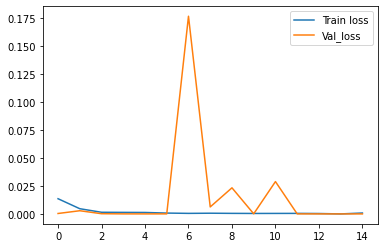

In [ ]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.legend()

In [ ]:
#Save model to cosin.h5 file
model.save('/content/gdrive/My Drive/data/stereo_matching/model_BC_self_learning.h5')